In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

### 1D Gaussian distribution approximation using GAN

In [2]:
# Data distribution --> Gaussian
class DataDistribution:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def sample(self, num_samples):
        samples = np.random.normal(self.mean, self.std, num_samples)
        samples.sort()
        return samples

In [3]:
mean = 1.0
std = 1.5
data = DataDistribution(mean, std)

(array([  2.,   7.,   9.,  22.,  56.,  72., 129., 161., 231., 268., 275.,
        251., 204., 138.,  80.,  51.,  25.,   8.,   8.,   3.]),
 array([-4.14564319, -3.63898993, -3.13233667, -2.6256834 , -2.11903014,
        -1.61237688, -1.10572361, -0.59907035, -0.09241709,  0.41423617,
         0.92088944,  1.4275427 ,  1.93419596,  2.44084923,  2.94750249,
         3.45415575,  3.96080902,  4.46746228,  4.97411554,  5.4807688 ,
         5.98742207]),
 <a list of 20 Patch objects>)

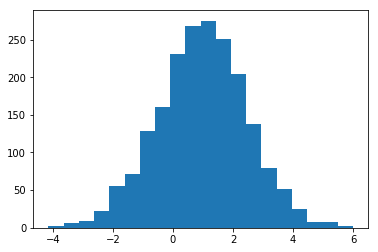

In [4]:
n_bins=20
data_sample = data.sample(2000)
plt.hist(data_sample, n_bins)

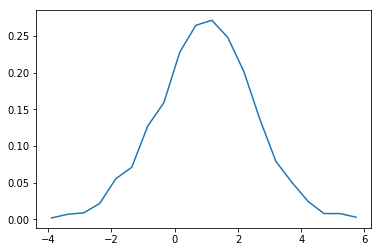

In [5]:
## Different plottling style
prob, bins = np.histogram(data_sample, n_bins, density=True)
xval = (bins[1:] + bins[:-1])/2.
plt.plot(xval, prob)

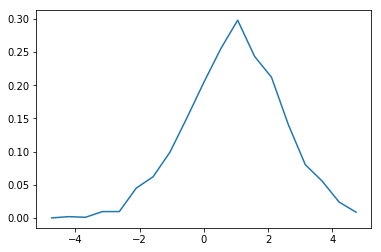

In [6]:
## Global bins defined here
data_range = 5
global_bins = np.linspace(-data_range, data_range, n_bins)
global_xvals = (global_bins[1:] + global_bins[:-1])/2.

prob,bins = np.histogram(data_sample, global_bins, density=True)
plt.plot(global_xvals, prob)

In [7]:
# Noise distribution -> Uniform Distribution
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples) * 0.01
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        return samples

In [8]:
noise = NoiseDistribution(data_range)

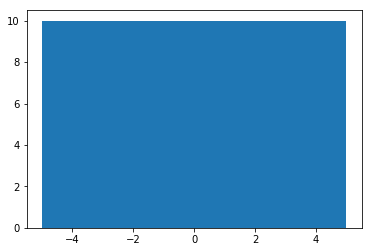

In [9]:
plt.hist(noise.sample(200), bins=n_bins)
plt.show()

In [10]:
# Generator model
class Generator(nn.Module):
    def __init__(self, n_hidden=32):
        super().__init__()

        self.layer0 = nn.Linear(1, n_hidden)
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.relu(x)
        x = self.layer1(x)
        return x

In [11]:
# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, n_hidden=32):
        super().__init__()

        self.layer0 = nn.Linear(1, n_hidden)
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer0(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        return x

In [12]:
G = Generator()
D = Discriminator()

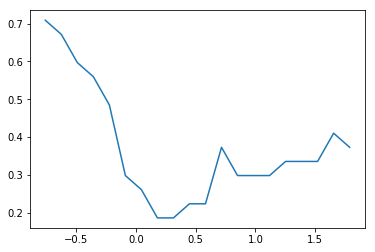

In [13]:
## For Generated values
noise_sample = noise.sample(200)
gen_data = G.forward(torch.Tensor(noise_sample.reshape(-1,1))).data.numpy()
prob, bins = np.histogram(gen_data, n_bins, density=True)
xval = (bins[1:] + bins[:-1])/2.
plt.plot(xval, prob)

In [14]:
## Pretraining the discriminator
learning_rate=0.03
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

D_pre_losses = []
num_samples_pre = 1000
num_bins_pre = 100
num_epochs_pre = 1000

for epoch in range(num_epochs_pre):
    # Generate samples
    d = data.sample(num_samples_pre)
    histc, edges = np.histogram(d, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)
#     x_ = edges[1:]
    x_ = (edges[1:]+edges[:-1])/2

    x_ = torch.Tensor(x_.reshape([num_bins_pre, 1]))
    y_ = torch.Tensor(y_.reshape([num_bins_pre, 1]))

    # Train model
    optimizer.zero_grad()
    D_pre_output = D(x_)
    D_pre_loss = loss_func(D_pre_output, y_)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.data.numpy())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.data.numpy())

0 0.6409279
100 0.5099871
200 0.4440207
300 0.40387592
400 0.37083057
500 0.4182057
600 0.43491733
700 0.4202296
800 0.4736586
900 0.42492202


In [15]:
# Optimizers
learning_rate=0.03
D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)
loss_func = torch.nn.BCELoss() # Binary Cross Entropy

D_losses = []
G_losses = []

In [16]:
batch_size = 150
num_epochs = 3000
num_samples = 10000

0 1.7861578 0.51277167
100 1.2657336 0.75421506
200 1.4027083 0.6808304
300 1.3600531 0.70148027
400 1.2686327 0.7200536
500 1.3722439 0.69848907
600 1.4177084 0.68366295
700 1.3776314 0.71371543
800 1.3565388 0.7669399
900 1.3603201 0.66521245
1000 1.3692659 0.7566132
1100 1.3698483 0.6493975
1200 1.37092 0.7552154
1300 1.3880022 0.733677
1400 1.3597374 0.70166904
1500 1.3674401 0.68037385
1600 1.3535314 0.7169937
1700 1.3903558 0.6706091
1800 1.3842659 0.66818935
1900 1.3878801 0.7624234
2000 1.3802742 0.7053937
2100 1.3860523 0.7056013
2200 1.3730509 0.70714897
2300 1.3842688 0.7728188
2400 1.3794559 0.7030959
2500 1.3731959 0.7083917
2600 1.3892081 0.7533112
2700 1.3929794 0.63023895
2800 1.3838927 0.7375636
2900 1.3756695 0.7187324


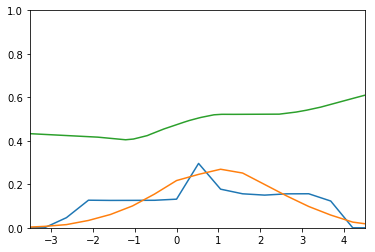

In [17]:
y_real_ = torch.ones([batch_size, 1])
y_fake_ = torch.zeros([batch_size, 1])

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(num_epochs):
    
    # Get Real samples
    x_ = data.sample(batch_size)
    x_ = torch.Tensor(x_.reshape(-1,1))
    # Train discriminator with real data
    D_real_output = D(x_)
    D_real_loss = loss_func(D_real_output, y_real_)

    # Generate samples
    z_ = noise.sample(batch_size)
    z_ = torch.Tensor(z_.reshape(-1,1))
    z_ = G(z_)
    
    # Train discriminator with fake data
    D_fake_output = D(z_)
    D_fake_loss = loss_func(D_fake_output, y_fake_)

    # Back propagation
    D_loss = (D_real_loss + D_fake_loss)#/2
    D.zero_grad()
    G.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = noise.sample(batch_size)
    z_ = torch.Tensor(z_.reshape(-1,1))
    z_ = G(z_)

    D_fake_output = D(z_)
    G_loss = loss_func(D_fake_output, y_real_) # if discriminator fails, generator wins

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.data.numpy())
    G_losses.append(G_loss.data.numpy())

    if epoch % 100 == 0:
        print(epoch, D_loss.data.numpy(), G_loss.data.numpy())
        ax.clear()
        ## For Generated values
        noise_sample = noise.sample(num_samples)
        gen_data = G.forward(torch.Tensor(noise_sample.reshape(-1,1))).data.numpy()
        prob, _ = np.histogram(gen_data, global_bins, density=True)
        plt.plot(global_xvals, prob, label='real data')

        ## For Real Data
        data_sample = data.sample(num_samples)
        prob, bins = np.histogram(data_sample, global_bins, density=True)
        plt.plot(global_xvals, prob, label='generated data')

        ## discriminative boundary
        x_sample = np.linspace(-data_range, data_range, num_samples)
        dis_data = D.forward(torch.Tensor(x_sample.reshape(-1,1))).data.numpy()
        plt.plot(x_sample, dis_data, label='decision boundary')

        maxy =  max(1, np.max(prob) * 1.1)
        plt.ylim(0,maxy)
        minx = max(mean - std * 3, -data_range * 0.9)
        miny = min(mean + std * 3, data_range * 0.9)
        plt.xlim(minx, miny)
        
        fig.canvas.draw()
        plt.pause(0.01)

(-3.5, 4.5)

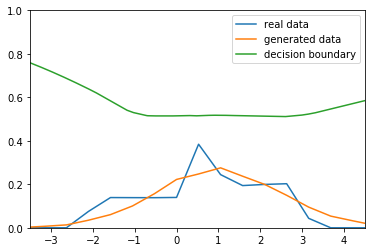

In [18]:
%matplotlib inline
## For Generated values
noise_sample = noise.sample(num_samples)
gen_data = G.forward(torch.Tensor(noise_sample.reshape(-1,1))).data.numpy()
prob, _ = np.histogram(gen_data, global_bins, density=True)
plt.plot(global_xvals, prob, label='real data')

## For Real Data
data_sample = data.sample(num_samples)
prob, bins = np.histogram(data_sample, global_bins, density=True)
plt.plot(global_xvals, prob, label='generated data')

## discriminative boundary
x_sample = np.linspace(-data_range, data_range, num_samples)
dis_data = D.forward(torch.Tensor(x_sample.reshape(-1,1))).data.numpy()
plt.plot(x_sample, dis_data, label='decision boundary')

plt.legend()
maxy =  max(1, np.max(prob) * 1.1)
plt.ylim(0,maxy)
minx = max(mean - std * 3, -data_range * 0.9)
miny = min(mean + std * 3, data_range * 0.9)
plt.xlim(minx, miny)

In [19]:
gen_data.mean(), gen_data.std()

(0.66987574, 1.3686876)